<a href="https://colab.research.google.com/github/Ignas12345/Project_in_Computational_Biology/blob/main/Part1_with_comparison_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**This notebook unifies the prievious notebooks into a single notebook.**

In [1]:
"""
Set Runtime -> Change runtime type -> Under Hardware Accelerator select GPU in Google Colab
"""
!git clone https://github.com/Nikronic/EdgeNet.git
!git clone https://github.com/Ignas12345/Project_in_Computational_Biology.git

Cloning into 'EdgeNet'...
remote: Enumerating objects: 127, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 127 (delta 2), reused 4 (delta 1), pack-reused 121
Receiving objects: 100% (127/127), 808.96 KiB | 3.49 MiB/s, done.
Resolving deltas: 100% (72/72), done.
Cloning into 'Project_in_Computational_Biology'...
remote: Enumerating objects: 186, done.
remote: Counting objects: 100% (108/108), done.
remote: Compressing objects: 100% (107/107), done.
remote: Total 186 (delta 40), reused 0 (delta 0), pack-reused 78
Receiving objects: 100% (186/186), 32.58 MiB | 16.31 MiB/s, done.
Resolving deltas: 100% (67/67), done.


In [2]:
import os
os.makedirs('DIP_images') #This folder will store images before the edge regularization
os.makedirs('Files_to_download') #This folder will store images of the edge map(/-s)
os.makedirs('Images_with_regularization') #This will store the images that we get after applying the edge map regularization

# Import libs

In [3]:
from Project_in_Computational_Biology.models import *
from PIL import Image
from Project_in_Computational_Biology.plotting import plot
from Project_in_Computational_Biology.converters import turn_to_grayscale, image_to_tensor, tensor_to_image, generate_noise

import torch
import torch.optim
from Project_in_Computational_Biology.models.downsampler import Downsampler
from EdgeNet.EdgeNet import EdgeNet

from Project_in_Computational_Biology.utils.sr_utils import *

#comment the following three lines if running on CPU

#torch.backends.cudnn.enabled = True
#torch.backends.cudnn.benchmark =True
#dtype = torch.cuda.FloatTensor

#and uncomment this line
dtype = torch.FloatTensor

upscaling_factor = 4

# Load image

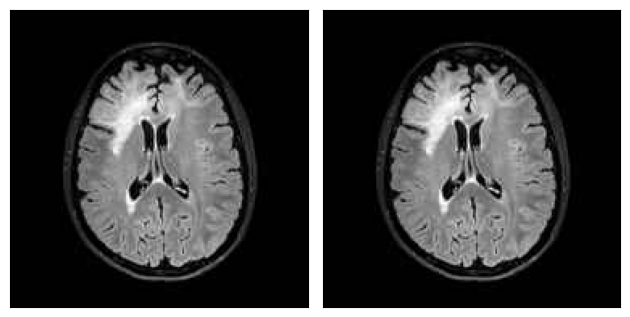

In [4]:
orig_img = Image.open('Project_in_Computational_Biology/pictures/images_with_ground_truth_1/Corrupted_4x.jpg')
gray_img = turn_to_grayscale(orig_img)
plot([orig_img, gray_img], cmap='gray') #Since both are exactly the same, we will use the grayscale version for speed and less complexity

# Set up parameters and net

In [10]:
INPUT =     'noise'
pad   =     'reflection'
OPT_OVER =  'net'
KERNEL_TYPE='lanczos2'

LR = 0.01
tv_weight = 0.0

OPTIMIZER = 'adam'

num_iter = 10
reg_noise_std = 0.05

In [ ]:
net_img = generate_noise(gray_img, upscaling_factor)
net_input = image_to_tensor(net_img).type(dtype).detach()
input_img = tensor_to_image(net_input)
input_img.save('Files_to_download/input_img.jpg')

In [11]:
NET_TYPE = 'skip' # UNet, ResNet
net = skip(
        num_input_channels=1, num_output_channels=1,
        num_channels_down=[16, 32, 64, 128, 128], num_channels_up=[16, 32, 64, 128, 128], num_channels_skip=[4, 4, 4, 4, 4],
        filter_size_down=3, filter_size_up=3, filter_skip_size=1,
        need_sigmoid=True, need_bias=True,
        pad='zero', upsample_mode='nearest', downsample_mode='stride', act_fun='LeakyReLU',
        need1x1_up=True).type(dtype)

# Losses
mse = torch.nn.MSELoss().type(dtype)

img_LR_var = image_to_tensor(gray_img).type(dtype)

downsampler = Downsampler(n_planes=1, factor=upscaling_factor, kernel_type=KERNEL_TYPE, phase=0.5, preserve_size=True).type(dtype)

In [ ]:
def closure():
    global i, net_input

    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)

    out_HR = net(net_input)
    out_LR = downsampler(out_HR)

    total_loss = mse(out_LR, img_LR_var)
    total_loss.backward()
    print('iteration: ' + str(i))

    if i % 25 == 0:
      output_img = tensor_to_image(out_HR)
      plot([gray_img, output_img], cmap = 'gray')
      output_img.save('DIP_images/High_resolution_iteration_' + str(i) + '.jpg')

    i += 1

    return total_loss

Starting optimization with ADAM
iteration: 0


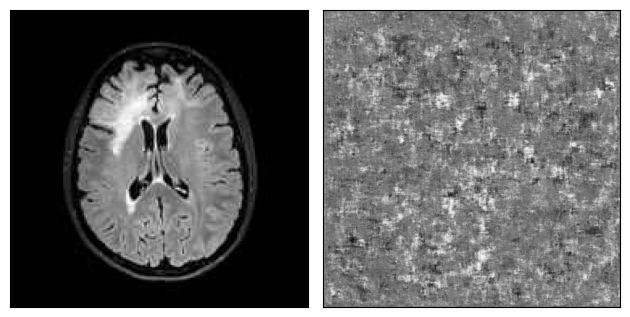

iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9


In [ ]:
psnr_history = []
net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()

i = 0
p = get_params(OPT_OVER, net, net_input)
optimize(OPTIMIZER, p, closure, LR, num_iter)

In [ ]:
torch.save(net.state_dict(), 'Files_to_download/model_parameters_DIP')

#**Only run this part if you have access to the ground truth**

In [5]:
from skimage.metrics import mean_squared_error

In [6]:
#Only run this part if you have access to the ground truth
ground_truth_img = Image.open('Project_in_Computational_Biology/pictures/images_with_ground_truth_1/Ground_truth.jpg')
gray_ground_truth_img = turn_to_grayscale(ground_truth_img)
gray_ground_truth_tensor = image_to_tensor(gray_ground_truth_img)

In [7]:
#here are the upscalings
bicubic_upscaling_img = gray_img.resize(gray_ground_truth_img.size, Image.BICUBIC)
bicubic_upscaling_img.save('Files_to_download/bicubic_upscaling.jpg')
bicubic_upscaling_tensor = image_to_tensor(bicubic_upscaling_img)

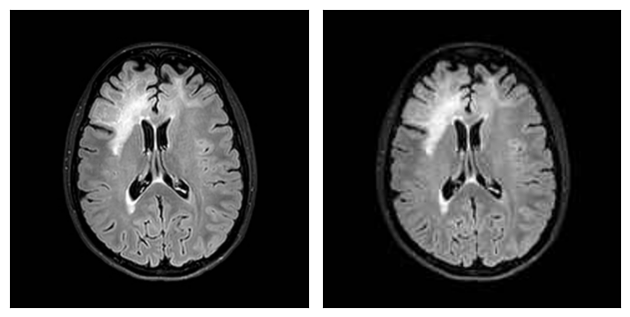

tensor(0.0010)

In [12]:
plot([gray_ground_truth_img, bicubic_upscaling_img], cmap='gray')
mse(gray_ground_truth_tensor, bicubic_upscaling_tensor)

In [13]:
nearest_upscaling_img = gray_img.resize(gray_ground_truth_img.size, Image.NEAREST)
nearest_upscaling_img.save('Files_to_download/nearest_upscaling.jpg')
nearest_upscaling_tensor = image_to_tensor(nearest_upscaling_img)

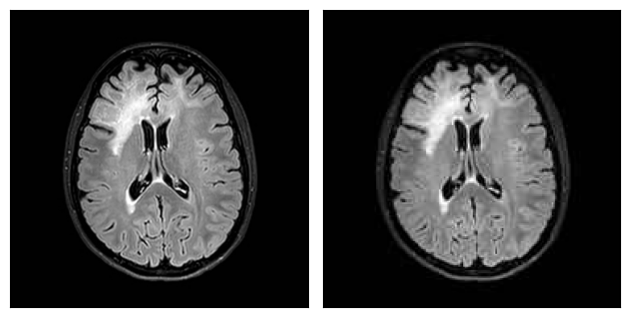

tensor(0.0016)

In [14]:
plot([gray_ground_truth_img, nearest_upscaling_img], cmap='gray')
mse(gray_ground_truth_tensor, nearest_upscaling_tensor)

In [15]:
import PIL

In [16]:
sharp_upscaling_img = bicubic_upscaling_img.filter(PIL.ImageFilter.UnsharpMask())
sharp_upscaling_img.save('Files_to_download/sharp_upscaling.jpg')
sharp_upscaling_tensor = image_to_tensor(sharp_upscaling_img)

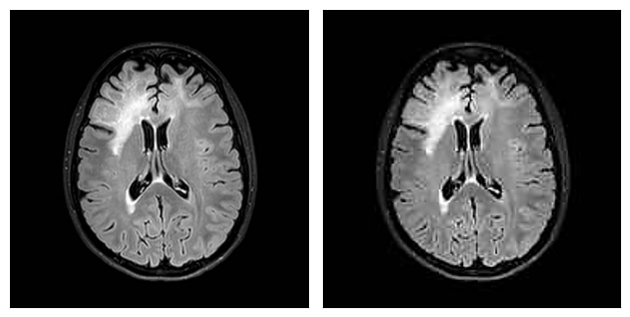

tensor(0.0012)

In [17]:
plot([gray_ground_truth_img, sharp_upscaling_img], cmap='gray')
mse(gray_ground_truth_tensor, sharp_upscaling_tensor)

In [20]:
DIP_upscaling_img = Image.open('underfitted_img.jpg')
DIP_upscaling_tensor = image_to_tensor(DIP_upscaling_img)

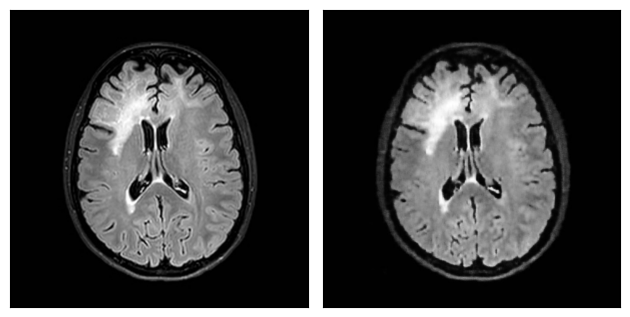

tensor(0.0012)

In [21]:
plot([gray_ground_truth_img, DIP_upscaling_img], cmap='gray')
mse(gray_ground_truth_tensor, DIP_upscaling_tensor)

In [32]:
edge_regulariztaion_upscaling_img = Image.open('High_resolution_iteration_after_edges3975.jpg')
edge_regulariztaion_upscaling_tensor = image_to_tensor(edge_regulariztaion_upscaling_img)

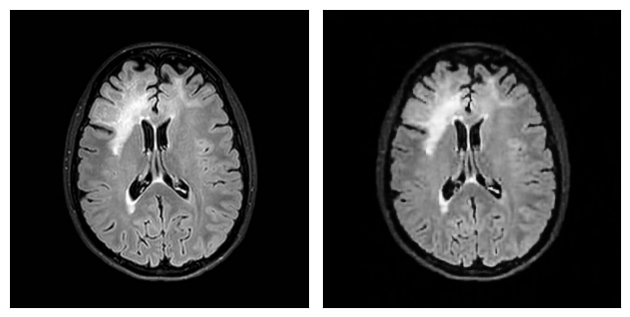

tensor(0.0009)

In [33]:
plot([gray_ground_truth_img, edge_regulariztaion_upscaling_img], cmap='gray')
mse(gray_ground_truth_tensor, edge_regulariztaion_upscaling_tensor)

# Now get the edge map

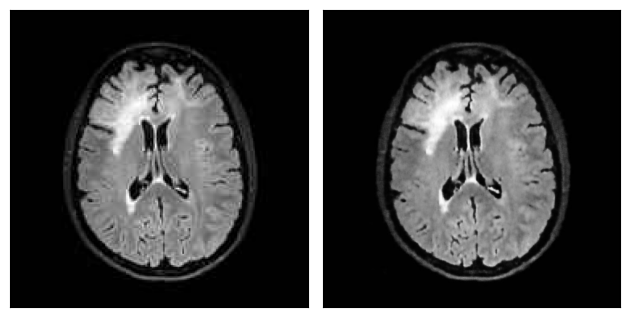

In [35]:
image_we_want_to_use = 175 #must be the number of the iteration that we consider not to have overfitted,  as we will drag back to it
underfitted_img = Image.open('underfitted_img.jpg')
plot([gray_img, underfitted_img], cmap='gray')

In [24]:
edgenet = EdgeNet(input_channels = 1).type(dtype)
#Here you can choose which parameters of EdgeNet You want to use. Each can give different results. It becomes like a sort of game at this point...
edgenet.load_state_dict(torch.load('Project_in_Computational_Biology/EdgeNet_parameters/model_parameters_3'))

<All keys matched successfully>

In [36]:
underfitted_edges_HR = edgenet(image_to_tensor(underfitted_img).type(dtype)).type(dtype).detach()
underfitted_edges_HR_img = tensor_to_image(underfitted_edges_HR)
underfitted_edges_LR = downsampler(underfitted_edges_HR).type(dtype).detach()
underfitted_edges_LR_img = tensor_to_image(underfitted_edges_LR)

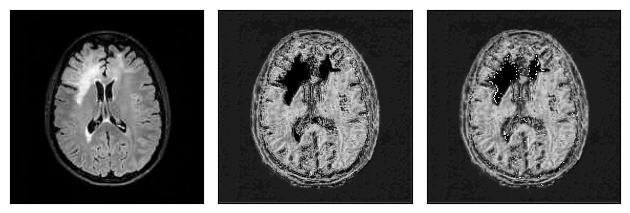

In [30]:
plot([underfitted_img, underfitted_edges_HR_img, underfitted_edges_LR_img], cmap = 'gray')

In [31]:
underfitted_edges_HR_img.save('Files_to_download/underfitted_edges_HR.jpg')
underfitted_edges_LR_img.save('Files_to_download/underfitted_edges_LR.jpg')

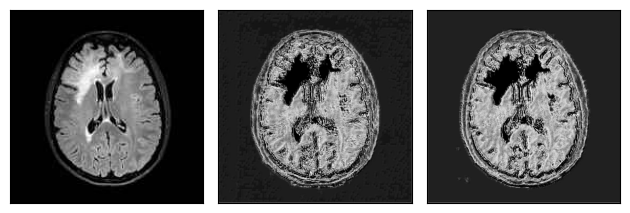

In [38]:
#here you can see how the underfitted edges would look
overfitted_img = Image.open('DIP_result.jpg')
overfitted_edges_HR = edgenet(image_to_tensor(overfitted_img).type(dtype)).type(dtype).detach()
overfitted_edges_HR_img = tensor_to_image(overfitted_edges_HR)
plot([gray_img, overfitted_edges_HR_img, underfitted_edges_HR_img], cmap = 'gray')

In [39]:
# maybe you can use this value in the next notebook as a typical value for the edge loss?
mse(underfitted_edges_HR, overfitted_edges_HR)

tensor(0.0331)

# Now apply the edge map Regularization

In [ ]:
edge_regularization_weight = 1

In [ ]:
def closure_with_edges():
    global i, net_input, edge_regularization_weight

    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)

    out_HR = net(net_input)
    out_LR = downsampler(out_HR)
    edges = edgenet(out_HR) #this can either be LR or HR. If LR, make sure that the underfitted edges image is downscaled via downsampler

    total_loss = mse(out_LR, img_LR_var)  + edge_regularization_weight * mse(edges, underfitted_edges_HR) # Here use underfitted_edges_LR if edges = out_LR and vicea-versea
    total_loss.backward()
    print('iteration: ' + str(i))

    if i % 25 == 0:
      output_img = tensor_to_image(out_HR)
      plot([gray_img, output_img], cmap = 'gray')
      output_img.save('High_resolution_iteration_after_edges' + str(i) + '.jpg')

    i += 1

    return total_loss

In [ ]:
net_after_edges = skip(
        num_input_channels=1, num_output_channels=1,
        num_channels_down=[16, 32, 64, 128, 128], num_channels_up=[16, 32, 64, 128, 128], num_channels_skip=[4, 4, 4, 4, 4],
        filter_size_down=3, filter_size_up=3, filter_skip_size=1,
        need_sigmoid=True, need_bias=True,
        pad='zero', upsample_mode='nearest', downsample_mode='stride', act_fun='LeakyReLU',
        need1x1_up=True).type(dtype)

net_after_edges.load_state_dict(torch.load('Files_to_download/model_parameters_DIP'))

<All keys matched successfully>

In [ ]:
#Run this to start from random noise again
net_img = generate_noise(gray_img, upscaling_factor)
net_input = image_to_tensor(net_img).type(dtype).detach()

In [ ]:
psnr_history = []
noise = net_input.detach().clone()
mse = torch.nn.MSELoss().type(dtype)
p = get_params(OPT_OVER, net_after_edges, net_input)
i = 0

Starting optimization with ADAM
iteration: 309
iteration: 310
iteration: 311
iteration: 312
iteration: 313
iteration: 314
iteration: 315
iteration: 316
iteration: 317
iteration: 318
iteration: 319
iteration: 320
iteration: 321
iteration: 322
iteration: 323
iteration: 324
iteration: 325


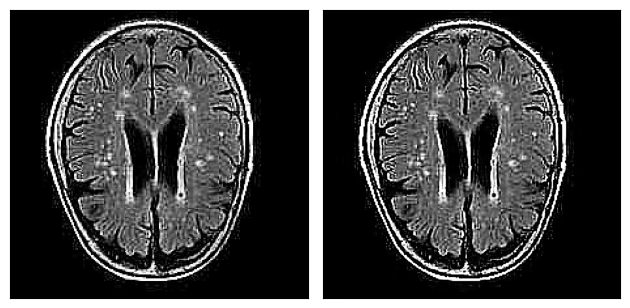

iteration: 326
iteration: 327
iteration: 328
iteration: 329
iteration: 330
iteration: 331
iteration: 332
iteration: 333
iteration: 334
iteration: 335
iteration: 336
iteration: 337
iteration: 338
iteration: 339
iteration: 340
iteration: 341
iteration: 342
iteration: 343
iteration: 344
iteration: 345
iteration: 346
iteration: 347
iteration: 348
iteration: 349
iteration: 350


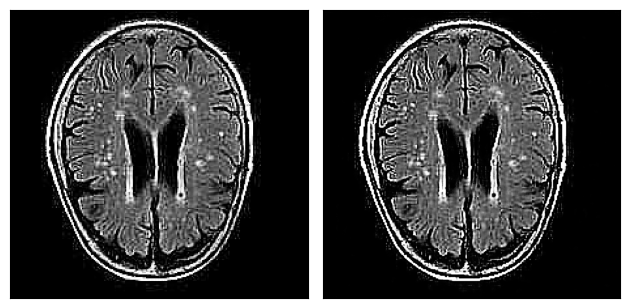

iteration: 351
iteration: 352
iteration: 353
iteration: 354
iteration: 355
iteration: 356
iteration: 357
iteration: 358
iteration: 359
iteration: 360
iteration: 361
iteration: 362
iteration: 363
iteration: 364
iteration: 365
iteration: 366
iteration: 367
iteration: 368
iteration: 369
iteration: 370
iteration: 371
iteration: 372
iteration: 373
iteration: 374
iteration: 375


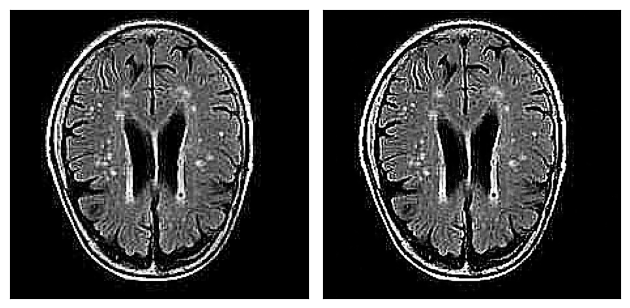

iteration: 376
iteration: 377
iteration: 378
iteration: 379
iteration: 380
iteration: 381
iteration: 382
iteration: 383
iteration: 384
iteration: 385
iteration: 386
iteration: 387
iteration: 388
iteration: 389
iteration: 390
iteration: 391
iteration: 392
iteration: 393
iteration: 394
iteration: 395
iteration: 396
iteration: 397
iteration: 398
iteration: 399
iteration: 400


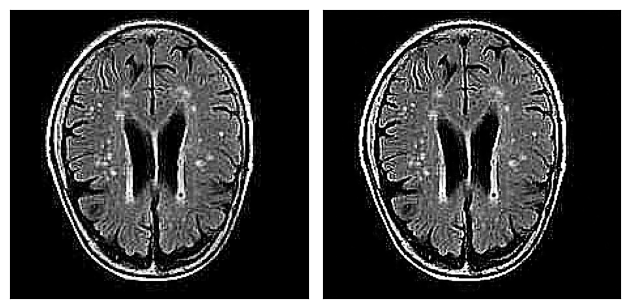

iteration: 401
iteration: 402
iteration: 403
iteration: 404
iteration: 405
iteration: 406
iteration: 407
iteration: 408
iteration: 409
iteration: 410
iteration: 411
iteration: 412
iteration: 413
iteration: 414
iteration: 415
iteration: 416
iteration: 417
iteration: 418
iteration: 419
iteration: 420
iteration: 421
iteration: 422
iteration: 423
iteration: 424
iteration: 425


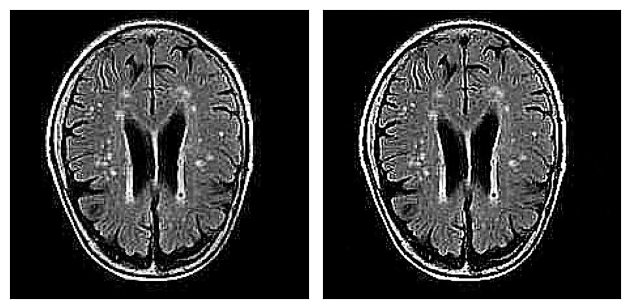

iteration: 426
iteration: 427
iteration: 428
iteration: 429
iteration: 430
iteration: 431
iteration: 432
iteration: 433
iteration: 434
iteration: 435
iteration: 436
iteration: 437
iteration: 438
iteration: 439
iteration: 440
iteration: 441
iteration: 442
iteration: 443
iteration: 444
iteration: 445
iteration: 446
iteration: 447
iteration: 448
iteration: 449
iteration: 450


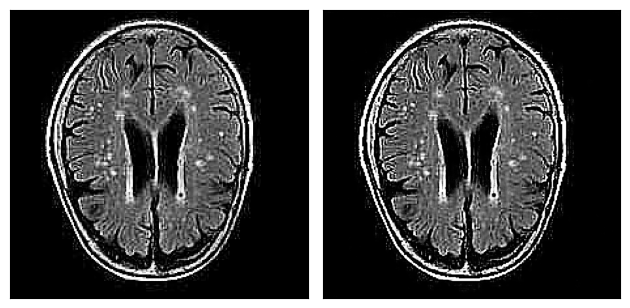

iteration: 451
iteration: 452
iteration: 453
iteration: 454
iteration: 455
iteration: 456
iteration: 457
iteration: 458
iteration: 459
iteration: 460
iteration: 461
iteration: 462
iteration: 463
iteration: 464
iteration: 465
iteration: 466
iteration: 467
iteration: 468
iteration: 469
iteration: 470
iteration: 471
iteration: 472
iteration: 473
iteration: 474
iteration: 475


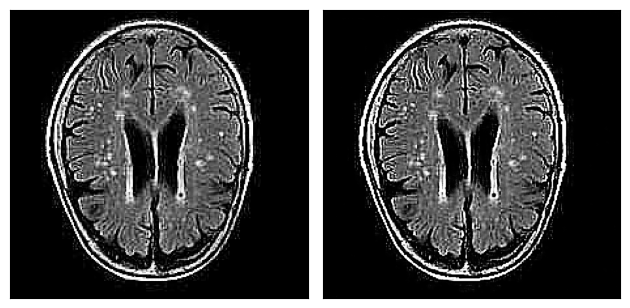

iteration: 476


KeyboardInterrupt: 

In [ ]:
optimize(OPTIMIZER, p, closure_with_edges, LR, num_iter)